In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from pathlib import Path

In [20]:
def get_dataset_path(filename="wikipedia_knowledge_base_balanced.csv"):
    """Auto-detect dataset path even when notebook is inside /notebooks folder."""
    
    base_paths = [
        Path.cwd(),
        Path.cwd().parent,  # go up one folder (for notebooks/)
    ]
    
    possible_dirs = ["data/raw", "data", "."]
    possible_paths = [b / d / filename for b in base_paths for d in possible_dirs]
    
    for p in possible_paths:
        if p.exists():
            print(f"📂 Dataset found: {p.resolve()}")
            return str(p)
    
    raise FileNotFoundError(
        f"❌ Dataset '{filename}' not found. Checked: {[str(p) for p in possible_paths]}"
    )

In [21]:
def analyze_knowledge_base(csv_path):
    """Comprehensive analysis of the knowledge base"""
    df = pd.read_csv(csv_path)

    print("=" * 60)
    print("KNOWLEDGE BASE ANALYSIS")
    print("=" * 60)
    print(f"Total articles: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Domain distribution
    print("\nDOMAIN DISTRIBUTION:")
    domain_counts = df['domain'].value_counts()
    for domain, count in domain_counts.items():
        print(f"  {domain}: {count} articles")

    # Basic content stats
    df["content_length"] = df["content"].str.len()
    if "word_count" not in df.columns:
        df["word_count"] = df["content"].apply(lambda x: len(str(x).split()))

    print("\nCONTENT STATISTICS:")
    print(f"  Avg word count: {df['word_count'].mean():.0f}")
    print(f"  Median: {df['word_count'].median():.0f}")
    print(f"  Min: {df['word_count'].min()} | Max: {df['word_count'].max()}")
    print(f"  Std dev: {df['word_count'].std():.0f}")
    print(f"  Avg char length: {df['content_length'].mean():.0f}")

    # Data quality checks
    print("\nDATA QUALITY:")
    print(f"  Missing values: {df.isnull().sum().sum()}")
    print(f"  Duplicate titles: {df['title'].duplicated().sum()}")
    print(f"  Empty content: {(df['content'].str.len() == 0).sum()}")

    # Sample articles
    print("\nSAMPLE ARTICLES:")
    for i in range(min(3, len(df))):
        print(f"\n  Article {i+1}: {df.iloc[i]['title']} ({df.iloc[i]['domain']})")
        print(f"    Word count: {df.iloc[i]['word_count']}")
        print(f"    Preview: {df.iloc[i]['content'][:150]}...")

    return df


In [22]:
def create_chunking_strategy(df, chunk_size=500, overlap=50):
    """Simulate basic fixed-size chunking and compute stats"""
    print("\n" + "=" * 60)
    print("CHUNKING STRATEGY ANALYSIS")
    print("=" * 60)

    total_chunks, chunk_stats = 0, []

    for _, row in df.iterrows():
        words = row["content"].split()
        for i in range(0, len(words), chunk_size - overlap):
            chunk_words = words[i:i + chunk_size]
            if len(chunk_words) > 50:
                total_chunks += 1
                chunk_stats.append({
                    "domain": row["domain"],
                    "article": row["title"],
                    "chunk_size": len(chunk_words),
                    "chunk_chars": len(" ".join(chunk_words))
                })

    chunk_sizes = [c["chunk_size"] for c in chunk_stats]
    print(f"  Chunk size: {chunk_size} words | Overlap: {overlap}")
    print(f"  Total chunks: {total_chunks}")
    print(f"  Avg chunks/article: {total_chunks / len(df):.1f}")
    print(f"  Avg chunk size: {np.mean(chunk_sizes):.0f} words")
    print(f"  Range: {min(chunk_sizes)} – {max(chunk_sizes)} words")

    return chunk_stats, total_chunks


In [23]:
def visualize_data(df, save_dir="reports/figures"):
    """Generate and save key visualizations"""
    os.makedirs(save_dir, exist_ok=True)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # (1) Domain distribution
    sns.countplot(data=df, x="domain", ax=axes[0, 0])
    axes[0, 0].set_title("Articles by Domain")
    axes[0, 0].tick_params(axis="x", rotation=30)

    # (2) Word count distribution
    axes[0, 1].hist(df["word_count"], bins=20, color="skyblue", edgecolor="black")
    axes[0, 1].set_title("Word Count Distribution")

    # (3) Boxplot by domain
    sns.boxplot(data=df, x="domain", y="word_count", ax=axes[1, 0])
    axes[1, 0].set_title("Word Count by Domain")
    axes[1, 0].tick_params(axis="x", rotation=30)

    # (4) Word vs character length
    axes[1, 1].scatter(df["word_count"], df["content_length"], alpha=0.6)
    axes[1, 1].set_title("Content Length vs Word Count")
    axes[1, 1].set_xlabel("Word Count")
    axes[1, 1].set_ylabel("Character Count")

    plt.tight_layout()
    fig_path = Path(save_dir) / "knowledge_base_analysis.png"
    plt.savefig(fig_path, dpi=200)
    plt.show()
    print(f"📊 Figure saved to: {fig_path}")

In [24]:
def run_step1_analysis():
    """Full analysis pipeline"""
    print("🚀 Starting Step 1: Data Analysis & Preprocessing")
    print("=" * 70)

    csv_path = get_dataset_path()
    df = analyze_knowledge_base(csv_path)
    chunk_stats, total_chunks = create_chunking_strategy(df)
    visualize_data(df)

    summary = {
        "total_articles": len(df),
        "domains": df["domain"].unique().tolist(),
        "avg_word_count": round(df["word_count"].mean(), 2),
        "total_chunks": total_chunks,
        "chunking_params": {"chunk_size": 500, "overlap": 50}
    }

    print("\n✅ Step 1 Complete!")
    print(f"Analyzed {summary['total_articles']} articles across {len(summary['domains'])} domains")
    print(f"Total chunks estimated: {summary['total_chunks']}")
    print("Ready for Step 2: Chunking and Embedding Creation")

    return df, summary

🚀 Starting Step 1: Data Analysis & Preprocessing
📂 Dataset found: /workspaces/Rag-Knowledge-Assiatant/data/wikipedia_knowledge_base_balanced.csv
KNOWLEDGE BASE ANALYSIS
Total articles: 150
Columns: ['title', 'domain', 'url', 'content', 'summary', 'word_count', 'scraped_at']
Memory usage: 11.62 MB

DOMAIN DISTRIBUTION:
  Science & Engineering: 30 articles
  Technology & Computing: 30 articles
  Mathematics & Statistics: 30 articles
  History & Geography: 30 articles
  Medicine & Health: 30 articles

CONTENT STATISTICS:
  Avg word count: 6215
  Median: 5830
  Min: 681 | Max: 17284
  Std dev: 3767
  Avg char length: 40271

DATA QUALITY:
  Missing values: 0
  Duplicate titles: 53
  Empty content: 0

SAMPLE ARTICLES:

  Article 1: Physics (Science & Engineering)
    Word count: 5374
    Preview: Physics is the scientific study of matter, its fundamental constituents, its motion and behavior through space and time, and the related entities of e...

  Article 2: Chemistry (Science & Engineeri

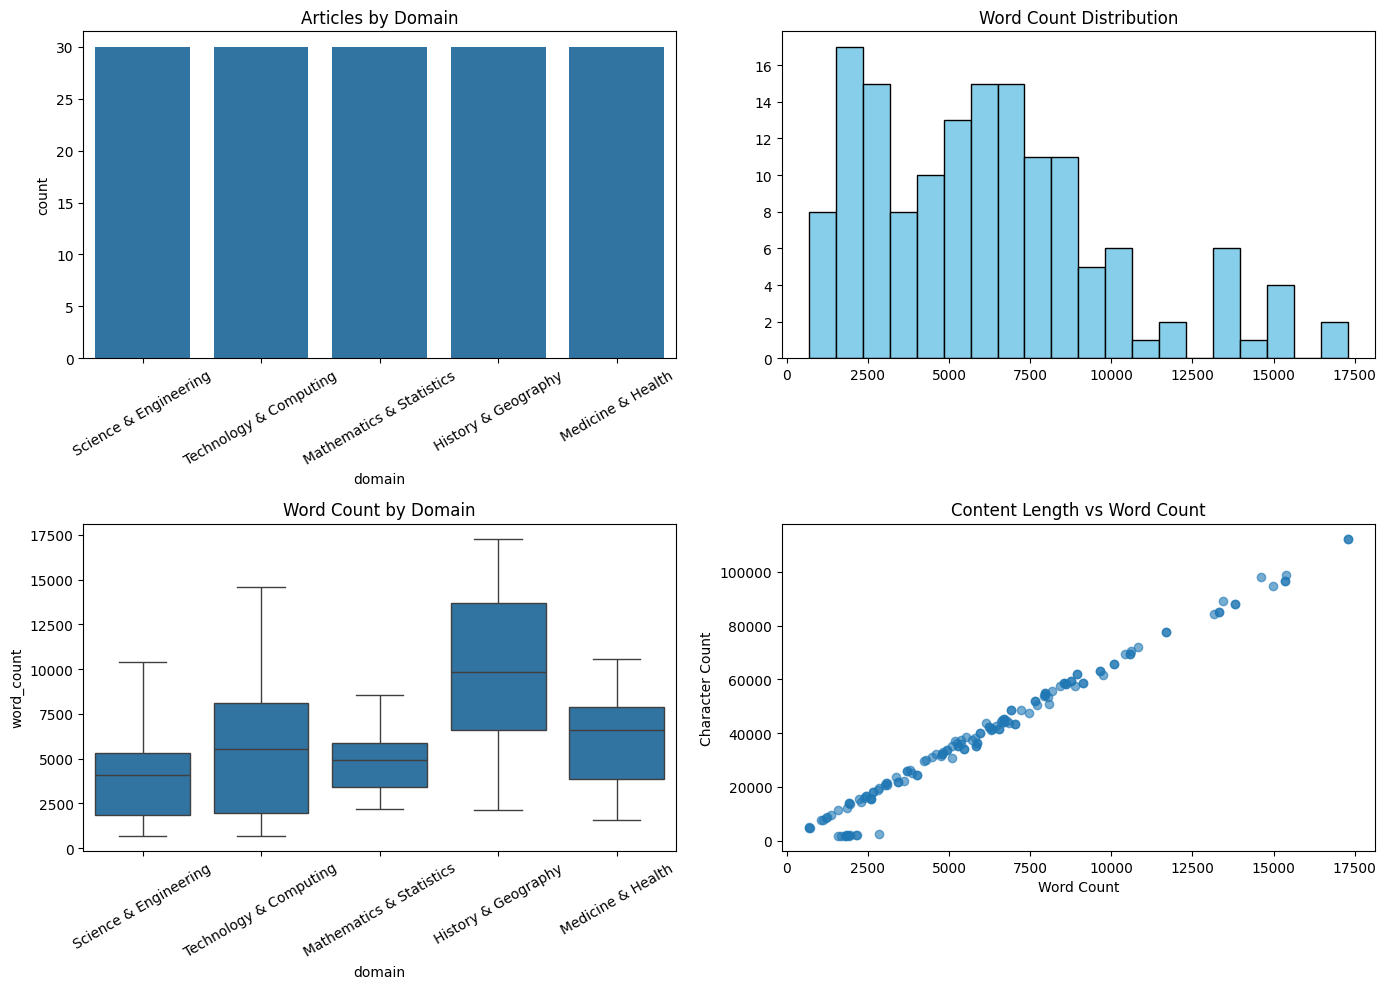

📊 Figure saved to: reports/figures/knowledge_base_analysis.png

✅ Step 1 Complete!
Analyzed 150 articles across 5 domains
Total chunks estimated: 2085
Ready for Step 2: Chunking and Embedding Creation


In [25]:
if __name__ == "__main__":
    df, summary = run_step1_analysis()